# Trabalho final: Raciocinio Espacial Neuro-Simbólico com LTNtorch
**Professor:** Edjard Mota

**Disciplina:** Fundamentos de Inteligência Artificial (ICC260)

**Alunos:**
* **André Kaled Duarte Coutinho Andrade** (andre.andrade@icomp.ufam.edu.br)
* **Conceição Barbosa Rocha** (conceicao.rocha@icomp.ufam.edu.br)
* **Julia Evelyn Chaparro Ferreira** (julia.ferreira@icomp.ufam.edu.br)
* **Luiz Henrique Barbosa Costa** (luiz.costa@icomp.ufam.edu.br)
* **Marcus Phablo Pereira de Oliveira** (marcus.oliveira@icomp.ufam.edu.br)
* **Paulo Victor Fernandes de Melo** (paulo.fernandes@icomp.ufam.edu.br)
* **Sven Maximilian Kalisch** (sven.kalisch@icomp.ufam.edu.br)
*
## Resumo do Projeto
Este projeto implementa um agente neuro-simbólico utilizando Logic Tensor Networks (LTN) para raciocinar sobre um ambiente simplificado. O objetivo é aprender e validar relações espaciais (esquerda, direita, acima, abaixo, entre) e atributos de objetos (forma, cor, tamanho) baseando-se em vetores de características, não em imagens brutas.

## Instalação e configuração inicial

In [1]:
import os
import sys

try:
    import ltn
    import torch
except ImportError:
    print("Instalando dependências... aguarde.")
    os.system(f'{sys.executable} -m pip install torch matplotlib numpy pandas --break-system-packages')
    os.system(f'{sys.executable} -m pip install git+https://github.com/logictensornetworks/LTNtorch.git --break-system-packages')
    print("Instalação concluída!")

import torch
import ltn
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import requests
torch.manual_seed(42)
print("Instalação e configuração finalizadas")

Instalando dependências... aguarde.
Instalação concluída!
Instalação e configuração finalizadas


# Tarefa 1: Taxonomia e Formas

## Geração de dados e plotagem


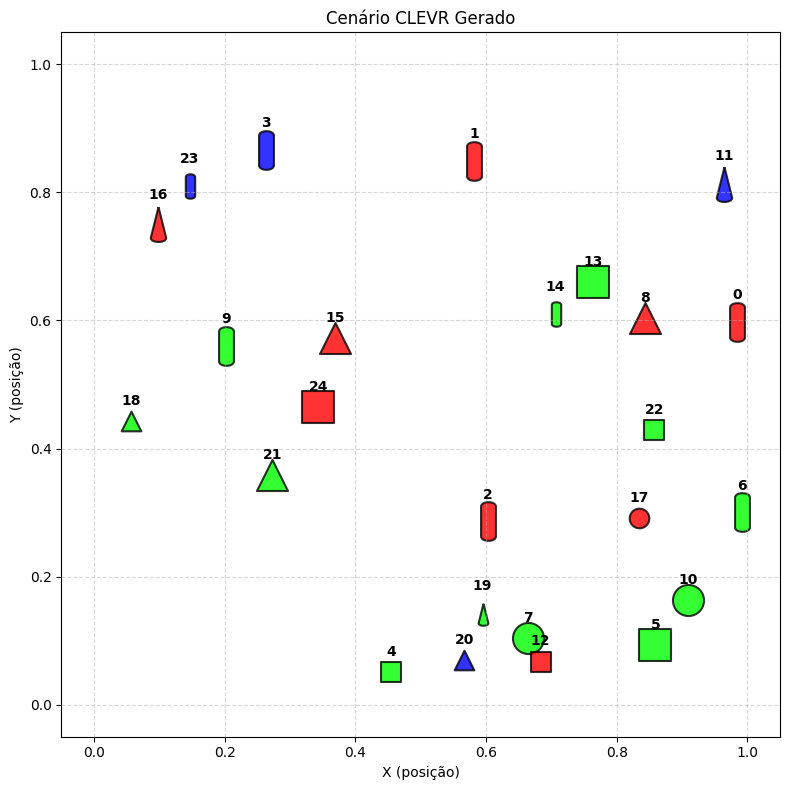

Dataset gerado. Shape: torch.Size([25, 11])
Exemplo: Large Red Cylinder
Vetor: tensor([0.9849, 0.5979, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 1.0000])


In [2]:
def get_custom_markers():
    """
    Cria caminhos (Paths) vetoriais para desenhar Cone e Cilindro
    com aparência 3D usando curvas de Bézier.
    """
    # Gemini que fez
    # --- CONE (Triângulo + Base Curva) ---
    verts_cone = [
        (0.0, 1.0),
        (-0.5, -1.0),
        (-0.5, -1.35),
        (0.5, -1.35),
        (0.5, -1.0),
        (0.0, 1.0)
    ]
    codes_cone = [
        mpath.Path.MOVETO,
        mpath.Path.LINETO,
        mpath.Path.CURVE4,
        mpath.Path.CURVE4,
        mpath.Path.CURVE4,
        mpath.Path.LINETO
    ]
    path_cone = mpath.Path(verts_cone, codes_cone)

    # --- CILINDRO (Retângulo + Topo/Base Curvos) ---
    verts_cyl = [
        (-0.5, 1.0),  # Topo Esq
        (-0.5, -1.0), # Baixo Esq
        (0.5, -1.0),  # Baixo Dir (Curva suave entre estes dois)
        (0.5, 1.0),   # Topo Dir
        (-0.5, 1.0),  # Volta Topo Esq (Curva suave entre estes dois)
        (-0.5, 0.95), # Um pequeno detalhe para fechar o "loop" visualmente
    ]
    codes_cyl = [
        mpath.Path.MOVETO,
        mpath.Path.LINETO,
        mpath.Path.CURVE4, # Controle 1 da base
        mpath.Path.CURVE4, # Controle 2 da base
        mpath.Path.CURVE4, # Fim da base
        mpath.Path.LINETO,
        mpath.Path.CURVE4, # Controle 1 do topo
        mpath.Path.CURVE4, # Controle 2 do topo
        mpath.Path.CURVE4  # Fim do topo
    ]

    verts_cyl_fixed = [
        (-0.5, 1.0),  # Start Top-Left
        (-0.5, -1.0), # Line to Bottom-Left

        # Curva de baixo (precisa de 2 pontos de controle + 1 final)
        (-0.5, -1.4), # Controle 1
        (0.5, -1.4),  # Controle 2
        (0.5, -1.0),  # Ponto Final (Bottom-Right)

        (0.5, 1.0),   # Line to Top-Right

        # Curva de cima (para fechar a tampa)
        (0.5, 1.4),   # Controle 1
        (-0.5, 1.4),  # Controle 2
        (-0.5, 1.0)   # Ponto Final (Top-Left)
    ]

    path_cyl = mpath.Path(verts_cyl_fixed, codes_cyl)

    return path_cone, path_cyl

def get_dataset_simplificado(n_exemplos=25):
    """
    Gera dataset CLEVR simplificado (x, y, cores, formas, tamanho).
    Vetor [11 features]:
    [0,1]: x, y
    [2,3,4]: r, g, b
    [5,6,7,8,9]: circle, square, cylinder, cone, triangle
    [10]: size (0=pequeno, 1=grande)
    """
    data = []
    labels = []

    nome_formas = ["Circle", "Square", "Cylinder", "Cone", "Triangle"]

    # rgb básico one-hot
    cores_disponiveis = {
        "Red": [1.0, 0.0, 0.0],
        "Green": [0.0, 1.0, 0.0],
        "Blue": [0.0, 0.0, 1.0]
    }
    lista_nomes_cores = list(cores_disponiveis.keys())
    nome_tamanhos  = ["Small", "Large"]

    for _ in range(n_exemplos):
        # posição
        x, y = np.random.rand(), np.random.rand()

        # cor
        cor_nome = np.random.choice(lista_nomes_cores)
        cor_vet = cores_disponiveis[cor_nome]

        # forma
        forma_idx = np.random.randint(0, 5)
        forma_vet = [0.0]*5
        forma_vet[forma_idx] = 1.0

        # tamanho
        grande = np.random.rand() > 0.5
        tamanho_val = 1.0 if grande else 0.0

        vet = [x, y] + cor_vet + forma_vet + [tamanho_val]
        data.append(vet)

        desc = f"{nome_tamanhos[int(tamanho_val)]} {cor_nome} {nome_formas[forma_idx]}"
        labels.append(desc)

    return torch.tensor(data, dtype=torch.float32), labels

def plot_dataset_simplificado(data, labels, title="Cenário CLEVR Gerado"):
    plt.figure(figsize=(8, 8))
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.grid(True, linestyle='--', alpha=0.5)
    marcador_cone, marcador_cilindro = get_custom_markers()

    # 0: circle, 1: square, 2: cylinder, 3:cone, 4:triangle
    marcadores = ['o', 's', marcador_cilindro, marcador_cone, '^']

    for i in range(len(data)):
        obj = data[i]
        x, y = obj[0].item(), obj[1].item()

        rgb_color = (obj[2].item(), obj[3].item(), obj[4].item())

        # Identificar forma (argmax dos indices 5,6,7,8,9)
        s_idx = torch.argmax(obj[5:10]).item()
        m = marcadores[s_idx]

        # tamanho (indice 10)
        size_val = obj[10].item()
        # grande: area=300, pequeno: area=100
        base_size = 500 if size_val > 0.5 else 200

        # cilindro ou cone
        if s_idx == 2 or s_idx == 3:
            base_size *= 1.8

        plt.scatter(x, y, c=[rgb_color], marker=m, s=base_size, edgecolors='black', label=labels[i], alpha=0.8, linewidths=1.5)
        offset = 0.035 if s_idx in [2,3] else 0.025
        plt.text(x, y+offset, str(i), fontsize=10, ha='center', fontweight='bold', color='black')

    plt.title(title)
    plt.xlabel("X (posição)")
    plt.ylabel("Y (posição)")
    plt.tight_layout()
    plt.show()

# testando
data_batch, text_labels = get_dataset_simplificado(25)
plot_dataset_simplificado(data_batch, text_labels)
print(f"Dataset gerado. Shape: {data_batch.shape}")
print(f"Exemplo: {text_labels[0]}")
print(f"Vetor: {data_batch[0]}")

## Criando a rede LTN (com predicados)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
data, text = get_dataset_simplificado(50)

objetos = ltn.Variable("objects", data)

print(f"Dataset gerado com sucesso! Formato: {data.shape}")
print("Exemplo de um objeto (x, y, r, g, b, s):")
print(data[0])

Dataset gerado com sucesso! Formato: torch.Size([50, 11])
Exemplo de um objeto (x, y, r, g, b, s):
tensor([0.7978, 0.4482, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000])


In [5]:
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
SatAgg = ltn.fuzzy_ops.AggregMean()

class MLP(nn.Module):
    def __init__(self, layer_sizes=(11, 16, 16, 1)):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                layers.append(nn.ELU())
        self.main = nn.Sequential(*layers)

    def forward(self, x):
      x = x.to(self.main[0].weight.device)
      x = self.main(x)
      return torch.sigmoid(x)


#formas
is_circle = ltn.Predicate(MLP().to(device))
is_square = ltn.Predicate(MLP().to(device))
is_cylinder = ltn.Predicate(MLP().to(device))
is_cone = ltn.Predicate(MLP().to(device))
is_triangle = ltn.Predicate(MLP().to(device))

# cores
is_red     = ltn.Predicate(MLP().to(device))
is_green   = ltn.Predicate(MLP().to(device))
is_blue    = ltn.Predicate(MLP().to(device))

# tamanhos
is_small = ltn.Predicate(MLP().to(device))
is_big = ltn.Predicate(MLP().to(device))

#juntando pra facilitar
formas_preds = [is_circle, is_square, is_cylinder, is_cone, is_triangle]
cores_preds = [
    is_red, is_green, is_blue
]

### Importando modelo treinado

Execute apenas se quiser pular o treinamento e testar um modelo pronto!

In [6]:
url = "https://github.com/ConcyRocha/FIA-Trabalho-Final/raw/main/ltn_model.pt"
filename = "ltn_model.pt"

if not os.path.exists(filename):
    print(f"Baixando {filename}...")
    response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(response.content)
    print("Download concluído!")
else:
    print("O arquivo já existe localmente")

checkpoint = torch.load("ltn_model.pt", map_location=device)

# Restaurar pesos
for name, pred in zip(["circle","square","cylinder","cone","triangle"], formas_preds):
    pred.model.load_state_dict(checkpoint["formas"][name])

for name, pred in zip(["Red","Green","Blue"], cores_preds):
    pred.model.load_state_dict(checkpoint["cores"][name])

is_small.model.load_state_dict(checkpoint["tamanhos"]["small"])
is_big.model.load_state_dict(checkpoint["tamanhos"]["big"])

print("Modelo carregado!")


Baixando ltn_model.pt...
Download concluído!
Modelo carregado!


## Definindo axiomas

In [6]:
def axiomas_logica(features_data):
    x = ltn.Variable("x", features_data.to(device))
    y = ltn.Variable("y", features_data.to(device))
    regras = []

    # regra pra nao ter duas formas ao mesmo tempo
    for i in range(len(formas_preds)):
        for j in range(i + 1, len(formas_preds)):
            f_i = formas_preds[i](x)
            f_j = formas_preds[j](x)
            regras.append(Forall(x, Not(And(f_i, f_j))))

    # regra pra escolher pelo menos uma forma
    uma_forma = formas_preds[0](x)
    for i in range(1, len(formas_preds)):
        uma_forma = Or(uma_forma, formas_preds[i](x))
    regras.append(Forall(x, uma_forma))

    # regra pra nao escolher mais de uma cor ao mesmo tempo
    for i in range(len(cores_preds)):
        for j in range(i + 1, len(cores_preds)):
            regras.append(Forall(x, Not(And(cores_preds[i](x), cores_preds[j](x)))))

    # regra pra forçar escolher uma cor
    pelo_menos_uma_cor = cores_preds[0](x)
    for i in range(1, len(cores_preds)):
        pelo_menos_uma_cor = Or(pelo_menos_uma_cor, cores_preds[i](x))
    regras.append(Forall(x, pelo_menos_uma_cor))

    regras.append(Forall(x, Not(And(is_small(x), is_big(x)))))
    regras.append(Forall(x, Or(is_small(x), is_big(x))))

    # Restrição de Proximidade
    same_size = Or(
        And(is_small(x), is_small(y)),
        And(is_big(x), is_big(y))
    )

    regras_triProx = Forall([x, y],
        Implies(
            And(is_triangle(x), And(is_triangle(y), CloseTo(x, y))),
            same_size
        )
    )
    regras.append(regras_triProx)

    if len(regras) == 0:
        return torch.tensor(1.0, device=device)

    # empilhar os tensores das fórmulas e mover para device
    regra_tensors = [r.value.to(device) for r in regras]
    return SatAgg(torch.stack(regra_tensors))

def axiomas_supervisao(data, labels):
    regras_sup = []
    mapa_formas = {"Circle": is_circle, "Square": is_square, "Cylinder": is_cylinder, "Cone": is_cone, "Triangle": is_triangle}
    mapa_cores = {
        "Red": is_red, "Green": is_green, "Blue": is_blue
    }
    mapa_tamanhos = {"Small": is_small, "Large": is_big}

    # Supervisão para Formas
    for nome, predicado in mapa_formas.items():
        idx_pos = [i for i, label in enumerate(labels) if nome in label]
        idx_neg = [i for i, label in enumerate(labels) if nome not in label]

        if len(idx_pos) > 0:
            x_pos = ltn.Variable(f"x_pos_{nome}", data[idx_pos].to(device))
            regras_sup.append(Forall(x_pos, predicado(x_pos)))
        if len(idx_neg) > 0:
            x_neg = ltn.Variable(f"x_neg_{nome}", data[idx_neg].to(device))
            regras_sup.append(Forall(x_neg, Not(predicado(x_neg))))

    # Supervisão para Cores
    for nome, predicado in mapa_cores.items():
        idx_pos = [i for i, label in enumerate(labels) if nome in label]
        idx_neg = [i for i, label in enumerate(labels) if nome not in label]

        if len(idx_pos) > 0:
            x_pos = ltn.Variable(f"x_pos_{nome}", data[idx_pos].to(device))
            regras_sup.append(Forall(x_pos, predicado(x_pos)))
        if len(idx_neg) > 0:
            x_neg = ltn.Variable(f"x_neg_{nome}", data[idx_neg].to(device))
            regras_sup.append(Forall(x_neg, Not(predicado(x_neg))))

    for nome, predicado in mapa_tamanhos.items():
        idx_pos = [i for i, label in enumerate(labels) if nome in label]
        idx_neg = [i for i, label in enumerate(labels) if nome not in label]

        if len(idx_pos) > 0:
            x_pos = ltn.Variable(f"x_pos_{nome}", data[idx_pos].to(device))
            regras_sup.append(Forall(x_pos, predicado(x_pos)))
        if len(idx_neg) > 0:
            x_neg = ltn.Variable(f"x_neg_{nome}", data[idx_neg].to(device))
            regras_sup.append(Forall(x_neg, Not(predicado(x_neg))))

    if len(regras_sup) == 0:
        return torch.tensor(1.0, device=device)

    regra_tensors = [r.value.to(device) for r in regras_sup]
    return SatAgg(torch.stack(regra_tensors))

## Tarefa 2: Raciocínio espacial


In [7]:
class RelacaoEspacial(nn.Module):
    def __init__(self, mode):
        super(RelacaoEspacial, self).__init__()
        self.mode = mode
        self.sigma = 15.0

    def forward(self, *inputs):
        if len(inputs) == 1 and isinstance(inputs[0], (list, tuple)):
            obj_a, obj_b = inputs[0][0], inputs[0][1]
        else:
            obj_a, obj_b = inputs[0], inputs[1]

        # Garante que não temos dimensões extras (ex: [1, 1, 11] -> [1, 11])
        if obj_a.ndim > 2:
            obj_a = obj_a.squeeze(1)
        if obj_b.ndim > 2:
            obj_b = obj_b.squeeze(1)

        if obj_a.shape[-1] < 2:
            # se ainda estiver errado, retorna 0
            return torch.zeros((obj_a.shape[0], 1), device=obj_a.device)

        xa, ya = obj_a[:, 0], obj_a[:, 1]
        xb, yb = obj_b[:, 0], obj_b[:, 1]

        if self.mode == "left":
            return torch.sigmoid(self.sigma * (xb - xa))
        elif self.mode == "right":
            return torch.sigmoid(self.sigma * (xa - xb))
        elif self.mode == "below":
            return torch.sigmoid(self.sigma * (yb - ya))
        elif self.mode == "above":
            return torch.sigmoid(self.sigma * (ya - yb))
        elif self.mode == "close":
            eucl_sq = (xa - xb)**2 + (ya - yb)**2
            return torch.exp(-2.0 * eucl_sq * (self.sigma/2))

        return torch.zeros_like(xa)

# Recriando os predicados com a classe
LeftOf = ltn.Predicate(RelacaoEspacial("left"))
RightOf = ltn.Predicate(RelacaoEspacial("right"))
Below = ltn.Predicate(RelacaoEspacial("below"))
Above = ltn.Predicate(RelacaoEspacial("above"))
CloseTo = ltn.Predicate(RelacaoEspacial("close"))

### axiomas

In [8]:
def bloco_axiomas_fundamentais(data):
    """
    Verifica as propriedades lógicas básicas:
    Irreflexividade, Assimetria, Inverso e Transitividade.
    """
    x = ltn.Variable("x", data)
    y = ltn.Variable("y", data)
    z = ltn.Variable("z", data)

    regras = []

    # Irreflexividade: x não pode estar à esquerda de si mesmo
    regras.append(Forall(x, Not(LeftOf(x, x))))

    # Assimetria: Se x < y, então y não pode ser < x
    regras.append(Forall([x, y],
        Implies(LeftOf(x, y), Not(LeftOf(y, x)))
    ))

    # Inverso: Esquerda <-> Direita (Se x < y então y > x)
    regras.append(Forall([x, y],
        ltn.Connective(ltn.fuzzy_ops.Equiv())(LeftOf(x, y), RightOf(y, x))
    ))

    # Transitividade: Se x < y E y < z, então x < z
    regras.append(Forall([x, y, z],
        Implies(And(LeftOf(x, y), LeftOf(y, z)), LeftOf(x, z))
    ))

    # Retorna a satisfação agregada dessas regras
    tensors = [r.value for r in regras]
    return SatAgg(torch.stack(tensors))

### Raciocínio Horizontal

In [9]:
def InBetween(x, y, z):
    """
    Define se x está entre y e z.
    Lógica: (y < x < z) OU (z < x < y)
    """
    return Or(
        And(LeftOf(y, x), RightOf(z, x)),
        And(LeftOf(z, x), RightOf(y, x))
    )

def bloco_raciocinio_horizontal(data):
    x = ltn.Variable("x", data)
    y = ltn.Variable("y", data)
    z = ltn.Variable("z", data)

    consultas = {}

    # LastOnTheLeft: Existe um x que está à esquerda de todos os outros?
    # Nota: Not(CloseTo) para evitar comparar x com ele mesmo
    consultas['LastLeft'] = Exists(x,
        Forall(y,
            Implies(Not(CloseTo(x, y)), LeftOf(x, y))
        )
    )

    # LastOnTheRight: Existe um x que está à direita de todos?
    # Nota: Not(CloseTo) para evitar comparar x com ele mesmo
    consultas['LastRight'] = Exists(x,
        Forall(y,
            Implies(Not(CloseTo(x, y)), RightOf(x, y))
        )
    )

    # InBetween: Existe algum trio válido (x entre y e z)?
    consultas['ExistsBetween'] = Exists([x, y, z], InBetween(x, y, z))

    # LeftOfAllSquares: "Existe objeto à Esquerda de todos os Quadrados"
    # Fórmula: ∃x(∀y(IsSquare(y) => LeftOf(x, y)))
    # Nota: Se não houver quadrados no cenário, essa regra é verdadeira para qualquer x.
    consultas['LeftOfAllSquares'] = Exists(x,
        Forall(y,
            Implies(is_square(y), LeftOf(x, y))
        )
    )

    # SquareRightOfCircle: "Todo Quadrado está à Direita de todo Círculo"
    # Fórmula: ∀x,y ((IsSquare(x) ^ IsCircle(y)) => RightOf(x, y))
    consultas['SquareRightOfCircle'] = Forall([x, y],
        Implies(
            And(is_square(x), is_circle(y)),
            RightOf(x, y)
        )
    )

    # Retorna o dicionário com os resultados individuais
    return {k: v.value.item() for k, v in consultas.items()}

## Tarefa 3: Raciocinio vertical


In [10]:
def CanStack(x, y):
    """
    Define se o objeto x pode ser empilhado sobre y.
    Regra: x deve estar ACIMA de y (Above)
           E a base y NÃO pode ser instável (não Cone e não Triângulo).
    """
    base_instavel = Or(is_cone(y), is_triangle(y))
    # Para empilhar: x está acima de y E a base y é estável
    return And(Above(x, y), Not(base_instavel))

def bloco_raciocinio_vertical(data):
    """
    Avalia as regras e consultas do Raciocínio Vertical (Tarefa 3).
    """
    x = ltn.Variable("x", data)
    y = ltn.Variable("y", data)
    z = ltn.Variable("z", data)

    consultas = {}

    # Inverso: Abaixo <-> Acima
    # Se x está abaixo de y, então y está acima de x (e vice-versa)
    # equivalência lógica (A <-> B)
    # (Below -> Above) AND (Above -> Below)
    consultas['VerticalInverse'] = Forall([x, y],
        And(
            Implies(Below(x, y), Above(y, x)),
            Implies(Above(y, x), Below(x, y))
        )
    )

    # Transitividade: Se x está abaixo de y E y está abaixo de z -> x está abaixo de z
    consultas['VerticalTransitivity'] = Forall([x, y, z],
        Implies(
            And(Below(x, y), Below(y, z)),
            Below(x, z)
        )
    )

    # CanStack: Existe algum par (x, y) onde o empilhamento é válido?
    consultas['ExistsStackable'] = Exists([x, y], CanStack(x, y))

    # Retorna o dicionário com os valores de satisfação (.value.item())
    return {k: v.value.item() for k, v in consultas.items()}

## Tarefa 4: Raciocinio composto

In [11]:
def bloco_raciocinio_composto(data):
    """
    Avalia as consultas complexas da Tarefa 4.
    """
    x = ltn.Variable("x", data)
    y = ltn.Variable("y", data)
    z = ltn.Variable("z", data)

    consultas = {}

    # Filtragem Composta
    consultas['T4.1_ComplexFilter'] = Exists(x,
        And(
            is_small(x),
            And(
                Exists(y, And(is_cylinder(y), Below(x, y))),
                Exists(z, And(is_square(z), LeftOf(x, z)))
            )
        )
    ).value.item()

    # Dedução da Posição Absoluta
    consultas['T4.2_GreenConeBetween'] = Exists([x, y, z],
        And(
            And(is_cone(x), is_green(x)),
            InBetween(x, y, z)
        )
    ).value.item()

    # T4.3 - Restrição de Proximidade (Triângulos próximos tem mesmo tamanho)
    same_size = Or(
        And(is_small(x), is_small(y)),
        And(is_big(x), is_big(y))
    )

    consultas['T4.3_TriProximity'] = Forall([x, y],
        Implies(
            And(is_triangle(x), And(is_triangle(y), CloseTo(x, y))),
            same_size
        )
    ).value.item()

    return consultas

## Treinamento

Iniciando Treinamento (Lógica + Supervisão)...
Epoch 0 | Sat Final: 0.6380 (Logica: 0.7774, Sup: 0.4986)
Epoch 100 | Sat Final: 0.9988 (Logica: 0.9977, Sup: 0.9998)
Epoch 200 | Sat Final: 0.9988 (Logica: 0.9977, Sup: 0.9999)
Epoch 300 | Sat Final: 0.9988 (Logica: 0.9977, Sup: 0.9999)
Epoch 400 | Sat Final: 0.9988 (Logica: 0.9978, Sup: 0.9999)
Epoch 500 | Sat Final: 0.9988 (Logica: 0.9978, Sup: 0.9999)
Epoch 600 | Sat Final: 0.9988 (Logica: 0.9978, Sup: 0.9999)
Epoch 700 | Sat Final: 0.9988 (Logica: 0.9978, Sup: 0.9999)
Epoch 800 | Sat Final: 0.9988 (Logica: 0.9978, Sup: 0.9999)
Epoch 900 | Sat Final: 0.9988 (Logica: 0.9978, Sup: 0.9999)


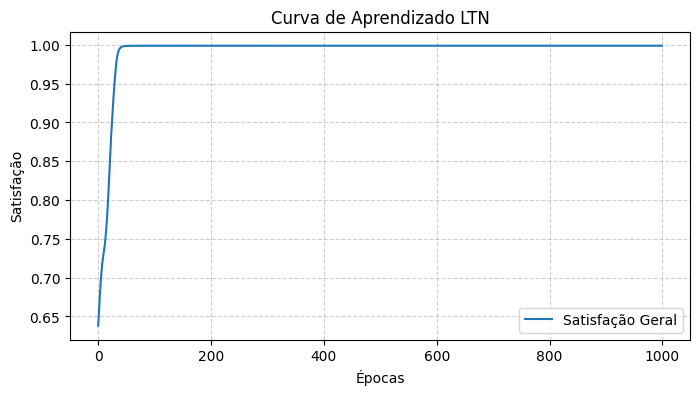

Treinamento Concluído!


In [12]:
all_preds = formas_preds + cores_preds + [is_small, is_big]
for p in all_preds:
    p.model.to(device)

# Coletamos parâmetros de todos os predicados para o otimizador
dados_treino, labels_treino = get_dataset_simplificado(n_exemplos=500)
dados_treino = dados_treino.to(device)

params = []
for p in all_preds:
    params += list(p.model.parameters())
optimizer = torch.optim.Adam(params, lr=0.01)

EPOCHS = 1000

print("Iniciando Treinamento (Lógica + Supervisão)...")
historico_loss = []


for epoch in range(EPOCHS):
    optimizer.zero_grad()

    # satisfação logica (regras internas)
    sat_logica = axiomas_logica(dados_treino)

    # satisfação supervisionada (aprender com Labels)
    sat_supervisao = axiomas_supervisao(dados_treino, labels_treino)

    # a rede deve obedecer a lógica e acertar os nomes
    sat_final = SatAgg(torch.stack([sat_logica, sat_supervisao]))

    # queremos minimizar o erro
    loss = 1.0 - sat_final

    loss.backward()
    optimizer.step()

    historico_loss.append(sat_final.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Sat Final: {sat_final.item():.4f} (Logica: {sat_logica.item():.4f}, Sup: {sat_supervisao.item():.4f})")

plt.figure(figsize=(8,4))
plt.plot(historico_loss, label="Satisfação Geral")
plt.xlabel("Épocas")
plt.ylabel("Satisfação")
plt.title("Curva de Aprendizado LTN")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("Treinamento Concluído!")

### Exportando modelo


In [13]:
checkpoint = {
    "formas": {name: pred.model.state_dict()
               for name, pred in zip(
                   ["circle","square","cylinder","cone","triangle"],
                   formas_preds
               )},
    "cores": {name: pred.model.state_dict()
              for name, pred in zip(
                  ["Red","Green","Blue"],
                  cores_preds
              )},
    "tamanhos": {
        "small": is_small.model.state_dict(),
        "big": is_big.model.state_dict()
    }
}

torch.save(checkpoint, "ltn_model.pt")
print("Modelo salvo em ltn_model.pt")


Modelo salvo em ltn_model.pt


## Entregas (Relatório)

==================== GERANDO RELATÓRIO FINAL (5 RODADAS) ====================


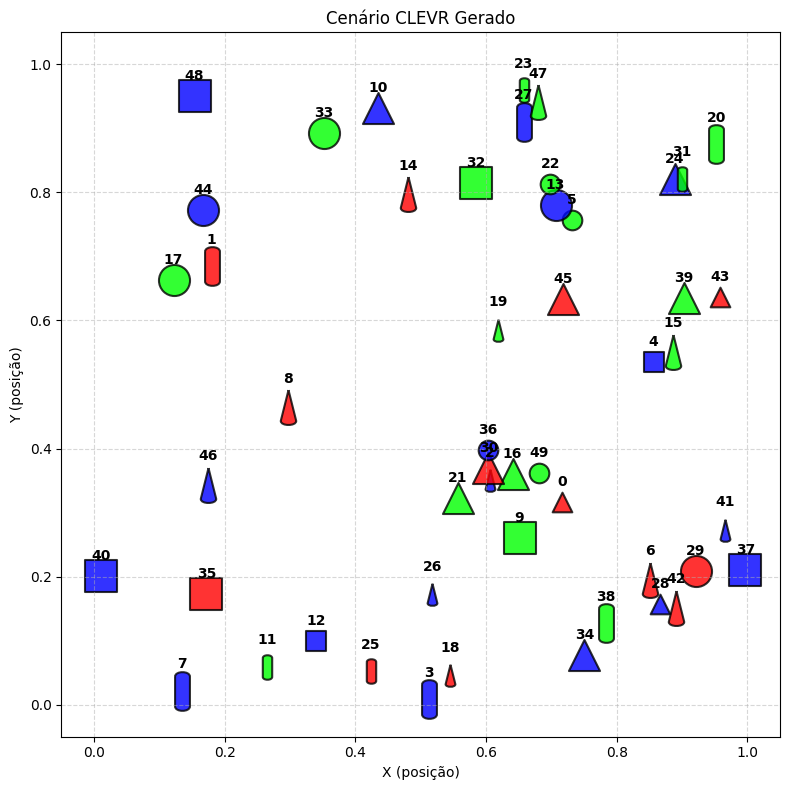

Execução 1: Acc=1.00 | F1=1.00 | Sat_Stack=0.48


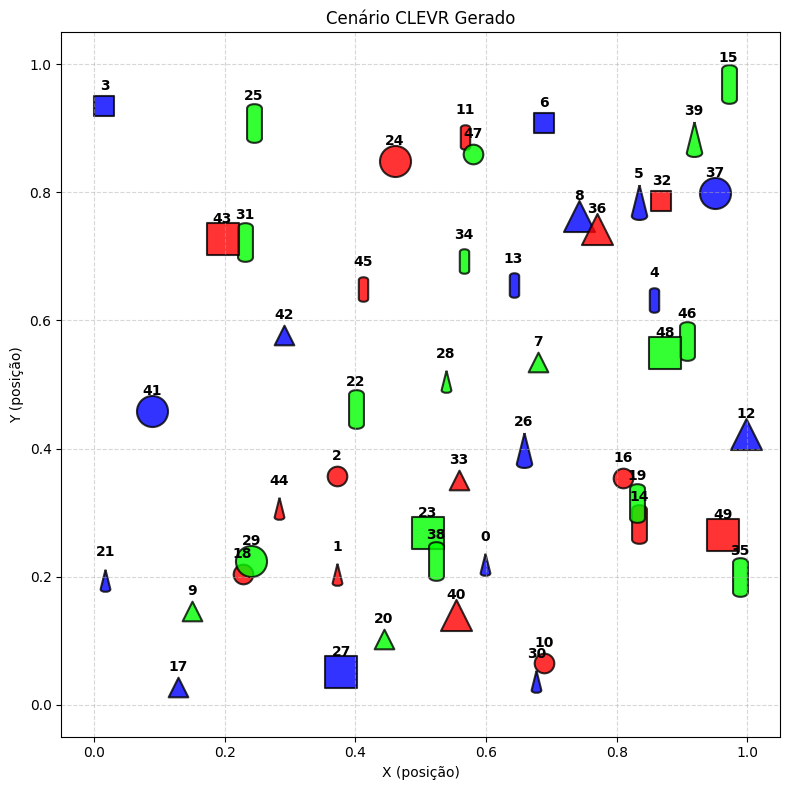

Execução 2: Acc=1.00 | F1=1.00 | Sat_Stack=0.48


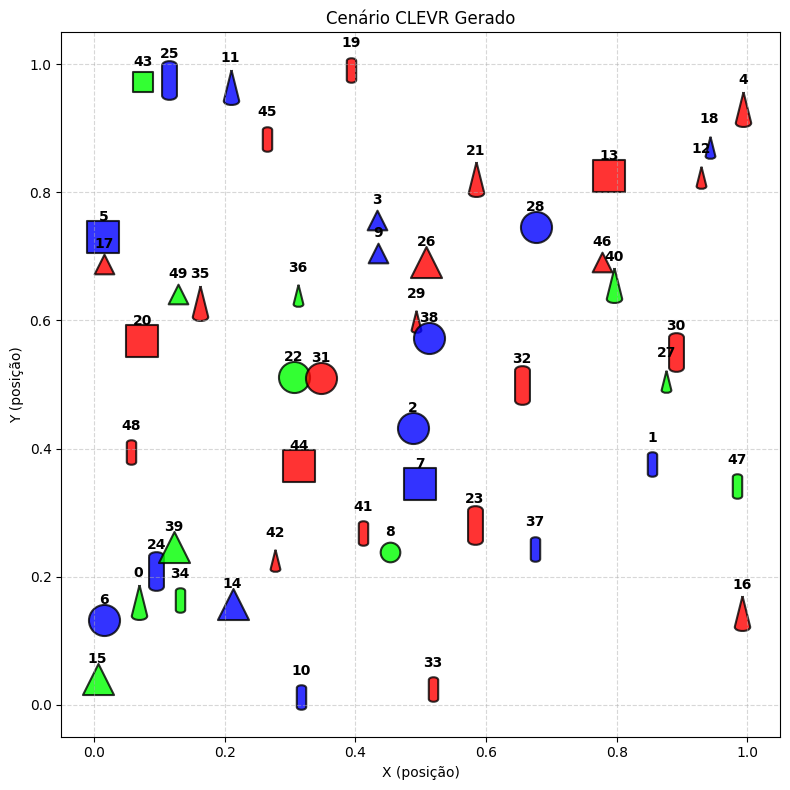

Execução 3: Acc=1.00 | F1=1.00 | Sat_Stack=0.52


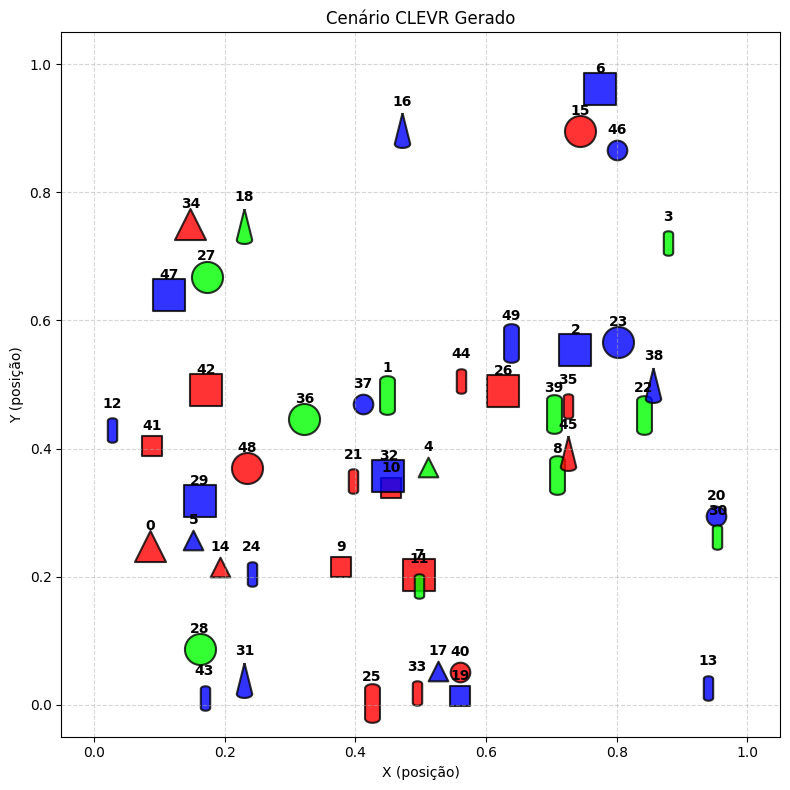

Execução 4: Acc=1.00 | F1=1.00 | Sat_Stack=0.58


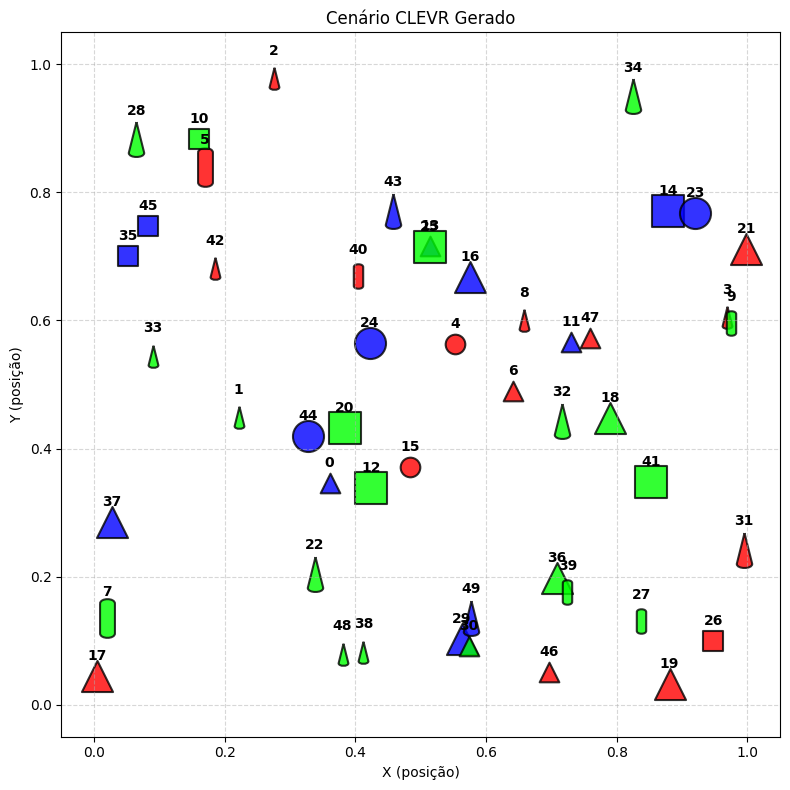

Execução 5: Acc=1.00 | F1=1.00 | Sat_Stack=0.39

TABELA FINAL DE RESULTADOS (MÉDIAS)


,Execução,Acurácia,Precision,Recall,F1-Score,Sat_LastLeft,Sat_InBetween,Sat_Inv_Vert,Sat_CanStack,Sat_ComplexFilter,Sat_GreenCone,Sat_TriProximity
0,1,1.0000,1.0000,1.0000,1.0000,0.5099,0.4757,0.8099,0.4757,0.0398,0.1277,0.9420
1,2,1.0000,1.0000,1.0000,1.0000,0.5164,0.4832,0.8095,0.4845,0.0849,0.0975,0.9667
2,3,1.0000,1.0000,1.0000,1.0000,0.5246,0.4859,0.8126,0.5226,0.0395,0.1281,0.9629
3,4,1.0000,1.0000,1.0000,1.0000,0.5497,0.4774,0.7953,0.5765,0.0819,0.0687,0.9647
4,5,1.0000,1.0000,1.0000,1.0000,0.5143,0.4872,0.8061,0.3908,0.0394,0.1959,0.9265
5,MÉDIA,1.0000,1.0000,1.0000,1.0000,0.5230,0.4819,0.8067,0.4900,0.0571,0.1236,0.9525


In [14]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

def calcular_metricas_classificacao(data, labels):
    """
    Compara a predição da rede com os labels reais para calcular Acurácia, F1, etc.
    """
    map_shapes = ["Circle", "Square", "Cylinder", "Cone", "Triangle"]
    map_colors = ["Red", "Green", "Blue"]
    map_sizes  = ["Small", "Large"]

    y_true_s, y_true_c, y_true_sz = [], [], []

    for l in labels:
        for i, s in enumerate(map_shapes):
            if s in l: y_true_s.append(i); break
        for i, c in enumerate(map_colors):
            if c in l: y_true_c.append(i); break
        for i, sz in enumerate(map_sizes):
            if sz in l: y_true_sz.append(i); break

    # Predições (O que a rede acha)
    # Formas
    logits_s = torch.cat([p.model(data) for p in formas_preds], dim=1)
    y_pred_s = torch.argmax(logits_s, dim=1).cpu().detach().numpy()

    # Cores
    logits_c = torch.cat([p.model(data) for p in cores_preds], dim=1)
    y_pred_c = torch.argmax(logits_c, dim=1).cpu().detach().numpy()

    # Tamanho
    logits_sz = torch.cat([is_small.model(data), is_big.model(data)], dim=1)
    y_pred_sz = torch.argmax(logits_sz, dim=1).cpu().detach().numpy()

    # 3. Calcular Médias
    acc = (accuracy_score(y_true_s, y_pred_s) +
           accuracy_score(y_true_c, y_pred_c) +
           accuracy_score(y_true_sz, y_pred_sz)) / 3.0

    f1 = (f1_score(y_true_s, y_pred_s, average='macro', zero_division=0) +
          f1_score(y_true_c, y_pred_c, average='macro', zero_division=0) +
          f1_score(y_true_sz, y_pred_sz, average='macro', zero_division=0)) / 3.0

    prec = (precision_score(y_true_s, y_pred_s, average='macro', zero_division=0) +
            precision_score(y_true_c, y_pred_c, average='macro', zero_division=0) +
            precision_score(y_true_sz, y_pred_sz, average='macro', zero_division=0)) / 3.0

    rec = (recall_score(y_true_s, y_pred_s, average='macro', zero_division=0) +
           recall_score(y_true_c, y_pred_c, average='macro', zero_division=0) +
           recall_score(y_true_sz, y_pred_sz, average='macro', zero_division=0)) / 3.0

    return acc, prec, rec, f1

# --- LOOP DE GERAÇÃO DA TABELA ---

print(f"{'='*20} GERANDO RELATÓRIO FINAL (5 RODADAS) {'='*20}")
resultados = []

for i in range(5):
    # 1. Dados Frescos
    data, labels = get_dataset_simplificado(n_exemplos=50)
    data = data.to(device)
    plot_dataset_simplificado(data, labels)

    # 2. Métricas de Classificação (Tarefa 1)
    acc, prec, rec, f1 = calcular_metricas_classificacao(data, labels)

    # 3. Satisfação Lógica (Tarefas 2, 3 e 4)
    # Chamando as funções que criamos
    res_horiz = bloco_raciocinio_horizontal(data)
    res_vert = bloco_raciocinio_vertical(data)
    res_comp = bloco_raciocinio_composto(data) # Tarefa 4

    # Organizar linha para o DataFrame
    linha = {
        "Execução": i + 1,
        # Métricas ML
        "Acurácia": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        # Tarefa 2 (Horizontal)
        "Sat_LastLeft": res_horiz['LastLeft'],
        "Sat_InBetween": res_horiz['ExistsBetween'],
        # Tarefa 3 (Vertical)
        "Sat_Inv_Vert": res_vert['VerticalInverse'],
        "Sat_CanStack": res_vert['ExistsStackable'],
        # Tarefa 4 (Composto)
        "Sat_ComplexFilter": res_comp['T4.1_ComplexFilter'],
        "Sat_GreenCone": res_comp['T4.2_GreenConeBetween'],
        "Sat_TriProximity": res_comp['T4.3_TriProximity']
    }
    resultados.append(linha)
    print(f"Execução {i+1}: Acc={acc:.2f} | F1={f1:.2f} | Sat_Stack={res_vert['ExistsStackable']:.2f}")

df_final = pd.DataFrame(resultados)

media = df_final.mean(numeric_only=True)
df_media = pd.DataFrame([media])
df_media["Execução"] = "MÉDIA"

# Concatenar
df_final = pd.concat([df_final, df_media], ignore_index=True)

cols = ["Execução"] + [c for c in df_final.columns if c != "Execução"]
df_final = df_final[cols]

print("\n" + "="*60)
print("TABELA FINAL DE RESULTADOS (MÉDIAS)")
print("="*60)
pd.set_option('display.float_format', '{:.4f}'.format)
display(df_final)

In [15]:
# Objeto 0: Quadrado, Vermelho, Grande em (0.5, 0.5)
# Objeto 1: Círculo, Azul, Pequeno em (0.2, 0.5) Está na ESQUERDA do Objeto 0
prova_data = torch.tensor([
    [0.5, 0.5, 1,0,0, 0,1,0,0,0, 1.0], # Quadrado Vermelho Grande
    [0.2, 0.5, 0,0,1, 1,0,0,0,0, 0.0]  # Círculo Azul Pequeno
], dtype=torch.float32).to(device)

x = ltn.Variable("x", prova_data[0:1]) # Quadrado
y = ltn.Variable("y", prova_data[1:2]) # Círculo

print(f"Círculo à esquerda do Quadrado? {LeftOf(y, x).value.item():.4f}")
print(f"Quadrado à direita do Círculo? {RightOf(x, y).value.item():.4f}")
print(f"O Quadrado é estável para empilhar? {Not(Or(is_cone(x), is_triangle(x))).value.item():.4f}")

Círculo à esquerda do Quadrado? 0.9890
Quadrado à direita do Círculo? 0.9890
O Quadrado é estável para empilhar? 1.0000
